# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [23]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

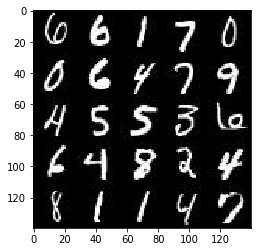

In [24]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

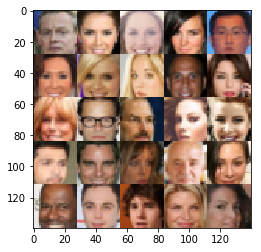

In [25]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [26]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [39]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input_image = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name="input_real")
    z_data = tf.placeholder(tf.float32, shape=(None,z_dim), name="input_z")
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")
    return real_input_image, z_data, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'File "/opt/co

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [80]:
def generateDiscriminatorLayer(x, size, alpha=0.2, kernel=5, strides=2, padding='same'):
    x1 = tf.layers.conv2d(x, size, kernel, strides=2, padding='same')
    x1 = tf.layers.batch_normalization(x1, training=True)
    lRelu = tf.maximum(alpha * x1, x1)
    return lRelu

def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.02
        # Input layer is 28x28x3 or 28x28x1
        x = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        x = tf.maximum(alpha * x, x)
        # 14 x 14 x 64
        
        x2 = generateDiscriminatorLayer(x, 128, alpha)
        # 7 x 7 x 128
        
        x3 = generateDiscriminatorLayer(x2, 256, alpha)
        # 4 x 4 x 256
        
        flaten = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flaten, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [81]:
def generateGeneratorLayer(x, size, alpha=0.2, training=True, kernel=5, strides=2, padding='same'):
    x2 = tf.layers.conv2d_transpose(x, size, kernel, strides=strides, padding=padding)
    x2 = tf.layers.batch_normalization(x2, training=training)
    x2 = tf.maximum(alpha * x2, x2)
    return x2

def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        alpha= 0.02
        # First fully connected layer
        x = tf.layers.dense(z, 4*4*1024)
        x = tf.reshape(x, (-1, 4, 4, 1024))
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)
        # 4 x 4 x 1024
        
        x2 = generateGeneratorLayer(x, 512, alpha, training=is_train, kernel=4, strides=1, padding='valid')
        # 7 x 7 x 512
        
        x3 = generateGeneratorLayer(x2, 256, alpha, training=is_train)
        # 14 x 14 x 256
        
        # Output layer, 28 x 28 x out_channel_dim
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28 x 28 x out_channel_dim
        
        out = tf.tanh(logits)
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [82]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [83]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [84]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [88]:
class GAN:
    def __init__(self, real_size, z_size, beta1=0.5):

        self.input_real, self.input_z, self.learning_rate = model_inputs(real_size[1], real_size[2], real_size[3], z_size)
        
        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z, real_size[3])
        
        self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, self.learning_rate, beta1)
        
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model

    net = GAN(data_shape, z_dim, beta1=beta1)
    
    print_every = 10
    show_every = 100
    steps = 0
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))
    d_losses = []
    g_losses = []
    images_display = 20
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                 # Run optimizers
                _ = sess.run(net.d_opt, feed_dict={net.input_real: batch_images, net.input_z: batch_z, net.learning_rate: learning_rate})
                _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z, net.input_real: batch_images, net.learning_rate: learning_rate})
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: batch_images,net.learning_rate: learning_rate})
                    train_loss_g = net.g_loss.eval({net.input_z: batch_z, net.learning_rate: learning_rate})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "batches {}".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    d_losses.append(train_loss_d)
                    g_losses.append(train_loss_g)

                if steps % show_every == 0:
                    show_generator_output(sess, images_display, net.input_z, data_shape[3], data_image_mode)
        # show the final output
        show_generator_output(sess, images_display, net.input_z, data_shape[3], data_image_mode)
        return d_losses, g_losses
                

In [86]:
%matplotlib inline
from matplotlib import pyplot as plt

def plot_losses(d_loss, g_loss):
    """
    Plot the discriminator and generator losses on the same graph
    :param d_loss: list of loss values for the discriminator
    :param g_loss: list of loss values for the generator
    """
    fig, ax = plt.subplots()
    plt.plot(d_loss, label='Discriminator', alpha=0.5)
    plt.plot(g_loss, label='Generator', alpha=0.5)
    plt.title("Training Losses")
    plt.legend()

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... batches 10 Discriminator Loss: 0.3794... Generator Loss: 2.9332
Epoch 1/2... batches 20 Discriminator Loss: 0.1847... Generator Loss: 6.7831
Epoch 1/2... batches 30 Discriminator Loss: 0.8230... Generator Loss: 0.6638
Epoch 1/2... batches 40 Discriminator Loss: 0.2035... Generator Loss: 2.2250
Epoch 1/2... batches 50 Discriminator Loss: 0.1177... Generator Loss: 2.4376
Epoch 1/2... batches 60 Discriminator Loss: 0.0430... Generator Loss: 8.9472
Epoch 1/2... batches 70 Discriminator Loss: 0.0430... Generator Loss: 3.6940
Epoch 1/2... batches 80 Discriminator Loss: 0.0621... Generator Loss: 3.5067
Epoch 1/2... batches 90 Discriminator Loss: 0.1861... Generator Loss: 2.8596
Epoch 1/2... batches 100 Discriminator Loss: 0.1445... Generator Loss: 7.9363


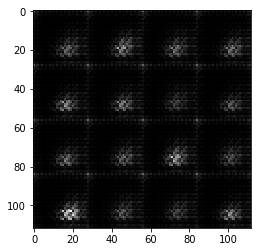

Epoch 1/2... batches 110 Discriminator Loss: 0.1087... Generator Loss: 4.3793
Epoch 1/2... batches 120 Discriminator Loss: 0.2263... Generator Loss: 3.6941
Epoch 1/2... batches 130 Discriminator Loss: 0.1380... Generator Loss: 2.8095
Epoch 1/2... batches 140 Discriminator Loss: 0.0907... Generator Loss: 6.2274
Epoch 1/2... batches 150 Discriminator Loss: 0.1387... Generator Loss: 2.7473
Epoch 1/2... batches 160 Discriminator Loss: 0.1312... Generator Loss: 2.8720
Epoch 1/2... batches 170 Discriminator Loss: 0.1093... Generator Loss: 6.2545
Epoch 1/2... batches 180 Discriminator Loss: 0.1135... Generator Loss: 3.6440
Epoch 1/2... batches 190 Discriminator Loss: 0.1318... Generator Loss: 3.2056
Epoch 1/2... batches 200 Discriminator Loss: 0.1011... Generator Loss: 3.4645


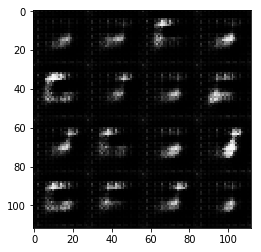

Epoch 1/2... batches 210 Discriminator Loss: 0.2158... Generator Loss: 2.7231
Epoch 1/2... batches 220 Discriminator Loss: 0.5306... Generator Loss: 7.4019
Epoch 1/2... batches 230 Discriminator Loss: 0.3271... Generator Loss: 3.6439
Epoch 1/2... batches 240 Discriminator Loss: 0.3998... Generator Loss: 2.0192
Epoch 1/2... batches 250 Discriminator Loss: 0.5083... Generator Loss: 4.2669
Epoch 1/2... batches 260 Discriminator Loss: 0.3402... Generator Loss: 2.3249
Epoch 1/2... batches 270 Discriminator Loss: 0.7192... Generator Loss: 1.0663
Epoch 1/2... batches 280 Discriminator Loss: 0.3814... Generator Loss: 1.9189
Epoch 1/2... batches 290 Discriminator Loss: 0.2891... Generator Loss: 3.8142
Epoch 1/2... batches 300 Discriminator Loss: 0.4899... Generator Loss: 1.9529


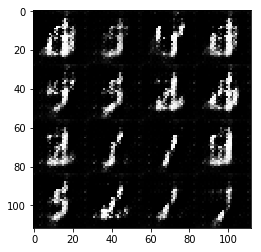

Epoch 1/2... batches 310 Discriminator Loss: 0.4176... Generator Loss: 1.6531
Epoch 1/2... batches 320 Discriminator Loss: 0.3426... Generator Loss: 3.2696
Epoch 1/2... batches 330 Discriminator Loss: 0.9231... Generator Loss: 0.9247
Epoch 1/2... batches 340 Discriminator Loss: 0.5341... Generator Loss: 1.7514
Epoch 1/2... batches 350 Discriminator Loss: 0.8068... Generator Loss: 2.2795
Epoch 1/2... batches 360 Discriminator Loss: 0.4512... Generator Loss: 2.1573
Epoch 1/2... batches 370 Discriminator Loss: 0.5802... Generator Loss: 2.6110
Epoch 1/2... batches 380 Discriminator Loss: 0.7108... Generator Loss: 1.2145
Epoch 1/2... batches 390 Discriminator Loss: 0.6806... Generator Loss: 1.6886
Epoch 1/2... batches 400 Discriminator Loss: 0.7188... Generator Loss: 1.7322


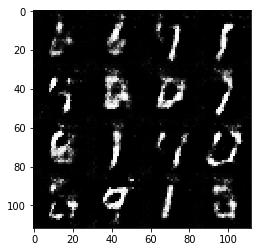

Epoch 1/2... batches 410 Discriminator Loss: 0.6418... Generator Loss: 1.4164
Epoch 1/2... batches 420 Discriminator Loss: 0.8744... Generator Loss: 1.3218
Epoch 1/2... batches 430 Discriminator Loss: 0.7727... Generator Loss: 1.8496
Epoch 1/2... batches 440 Discriminator Loss: 0.8927... Generator Loss: 1.7759
Epoch 1/2... batches 450 Discriminator Loss: 0.9466... Generator Loss: 0.8000
Epoch 1/2... batches 460 Discriminator Loss: 1.1789... Generator Loss: 0.5400
Epoch 2/2... batches 470 Discriminator Loss: 0.9096... Generator Loss: 2.0733
Epoch 2/2... batches 480 Discriminator Loss: 1.0463... Generator Loss: 0.7486
Epoch 2/2... batches 490 Discriminator Loss: 0.8463... Generator Loss: 1.0571
Epoch 2/2... batches 500 Discriminator Loss: 1.0127... Generator Loss: 2.0145


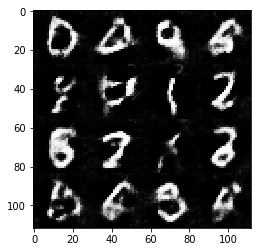

Epoch 2/2... batches 510 Discriminator Loss: 0.8507... Generator Loss: 1.2965
Epoch 2/2... batches 520 Discriminator Loss: 1.0265... Generator Loss: 1.8758
Epoch 2/2... batches 530 Discriminator Loss: 0.7723... Generator Loss: 1.3352
Epoch 2/2... batches 540 Discriminator Loss: 0.9489... Generator Loss: 0.9894
Epoch 2/2... batches 550 Discriminator Loss: 0.9997... Generator Loss: 0.9696
Epoch 2/2... batches 560 Discriminator Loss: 1.0265... Generator Loss: 0.7173
Epoch 2/2... batches 570 Discriminator Loss: 1.0477... Generator Loss: 1.6797
Epoch 2/2... batches 580 Discriminator Loss: 1.3011... Generator Loss: 0.4387
Epoch 2/2... batches 590 Discriminator Loss: 0.9739... Generator Loss: 1.1902
Epoch 2/2... batches 600 Discriminator Loss: 1.1241... Generator Loss: 0.6267


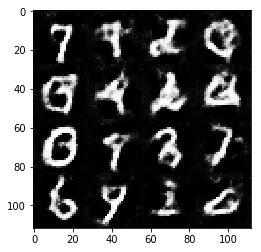

Epoch 2/2... batches 610 Discriminator Loss: 0.9809... Generator Loss: 1.5478
Epoch 2/2... batches 620 Discriminator Loss: 1.3309... Generator Loss: 0.4548
Epoch 2/2... batches 630 Discriminator Loss: 0.9793... Generator Loss: 0.8886
Epoch 2/2... batches 640 Discriminator Loss: 0.9952... Generator Loss: 1.3401
Epoch 2/2... batches 650 Discriminator Loss: 0.9416... Generator Loss: 1.0926
Epoch 2/2... batches 660 Discriminator Loss: 1.4696... Generator Loss: 0.3572
Epoch 2/2... batches 670 Discriminator Loss: 0.9984... Generator Loss: 0.7289
Epoch 2/2... batches 680 Discriminator Loss: 1.7230... Generator Loss: 0.2494
Epoch 2/2... batches 690 Discriminator Loss: 0.9356... Generator Loss: 1.1155
Epoch 2/2... batches 700 Discriminator Loss: 1.0814... Generator Loss: 0.9623


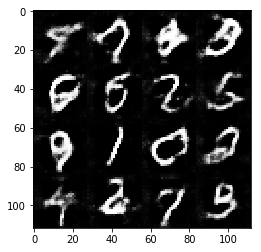

Epoch 2/2... batches 710 Discriminator Loss: 1.1104... Generator Loss: 1.5504
Epoch 2/2... batches 720 Discriminator Loss: 1.0304... Generator Loss: 0.8694
Epoch 2/2... batches 730 Discriminator Loss: 0.9826... Generator Loss: 0.8873
Epoch 2/2... batches 740 Discriminator Loss: 0.9677... Generator Loss: 1.0830
Epoch 2/2... batches 750 Discriminator Loss: 1.1163... Generator Loss: 0.6243
Epoch 2/2... batches 760 Discriminator Loss: 1.0493... Generator Loss: 0.7179
Epoch 2/2... batches 770 Discriminator Loss: 1.0474... Generator Loss: 1.4284
Epoch 2/2... batches 780 Discriminator Loss: 1.0310... Generator Loss: 0.8437
Epoch 2/2... batches 790 Discriminator Loss: 1.2204... Generator Loss: 0.5582
Epoch 2/2... batches 800 Discriminator Loss: 1.0373... Generator Loss: 0.8205


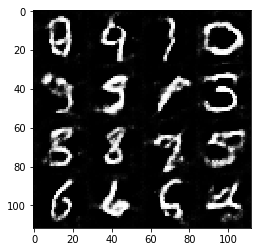

Epoch 2/2... batches 810 Discriminator Loss: 1.8518... Generator Loss: 0.2160
Epoch 2/2... batches 820 Discriminator Loss: 1.0556... Generator Loss: 0.7013
Epoch 2/2... batches 830 Discriminator Loss: 0.9958... Generator Loss: 0.8435
Epoch 2/2... batches 840 Discriminator Loss: 1.0539... Generator Loss: 0.9333
Epoch 2/2... batches 850 Discriminator Loss: 1.1626... Generator Loss: 0.5796
Epoch 2/2... batches 860 Discriminator Loss: 0.9677... Generator Loss: 1.3110
Epoch 2/2... batches 870 Discriminator Loss: 0.9544... Generator Loss: 1.1345
Epoch 2/2... batches 880 Discriminator Loss: 1.0089... Generator Loss: 0.9970
Epoch 2/2... batches 890 Discriminator Loss: 1.5367... Generator Loss: 0.3098
Epoch 2/2... batches 900 Discriminator Loss: 0.9795... Generator Loss: 1.1629


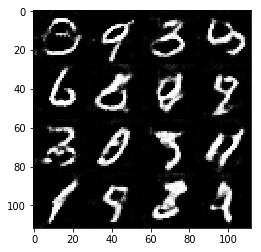

Epoch 2/2... batches 910 Discriminator Loss: 1.3527... Generator Loss: 0.4008
Epoch 2/2... batches 920 Discriminator Loss: 0.9611... Generator Loss: 0.8051
Epoch 2/2... batches 930 Discriminator Loss: 1.3405... Generator Loss: 2.0095


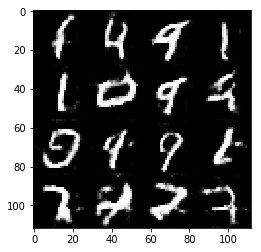

In [90]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

d_losses = []
g_losses = []

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    d_losses, g_losses = train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

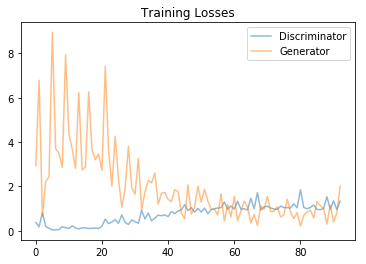

In [91]:
plot_losses(d_losses, g_losses)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... batches 10 Discriminator Loss: 0.6152... Generator Loss: 1.8326
Epoch 1/1... batches 20 Discriminator Loss: 0.4201... Generator Loss: 2.4794
Epoch 1/1... batches 30 Discriminator Loss: 0.2704... Generator Loss: 2.7535
Epoch 1/1... batches 40 Discriminator Loss: 0.4224... Generator Loss: 8.2014
Epoch 1/1... batches 50 Discriminator Loss: 0.4800... Generator Loss: 1.1211
Epoch 1/1... batches 60 Discriminator Loss: 0.3885... Generator Loss: 2.2742
Epoch 1/1... batches 70 Discriminator Loss: 0.2367... Generator Loss: 5.4312
Epoch 1/1... batches 80 Discriminator Loss: 0.2688... Generator Loss: 7.4432
Epoch 1/1... batches 90 Discriminator Loss: 0.4155... Generator Loss: 4.5610
Epoch 1/1... batches 100 Discriminator Loss: 0.3140... Generator Loss: 3.6987


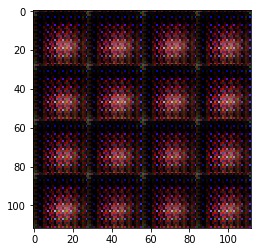

Epoch 1/1... batches 110 Discriminator Loss: 0.4462... Generator Loss: 1.6862
Epoch 1/1... batches 120 Discriminator Loss: 0.2709... Generator Loss: 2.0114
Epoch 1/1... batches 130 Discriminator Loss: 0.3162... Generator Loss: 2.2819
Epoch 1/1... batches 140 Discriminator Loss: 0.5720... Generator Loss: 5.5706
Epoch 1/1... batches 150 Discriminator Loss: 0.3044... Generator Loss: 1.7754
Epoch 1/1... batches 160 Discriminator Loss: 0.2454... Generator Loss: 2.1520
Epoch 1/1... batches 170 Discriminator Loss: 0.3000... Generator Loss: 2.4096
Epoch 1/1... batches 180 Discriminator Loss: 0.1448... Generator Loss: 3.0233
Epoch 1/1... batches 190 Discriminator Loss: 0.2264... Generator Loss: 2.4638
Epoch 1/1... batches 200 Discriminator Loss: 0.1753... Generator Loss: 2.9213


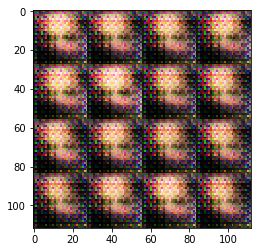

Epoch 1/1... batches 210 Discriminator Loss: 0.2482... Generator Loss: 2.3480
Epoch 1/1... batches 220 Discriminator Loss: 0.1951... Generator Loss: 2.7090
Epoch 1/1... batches 230 Discriminator Loss: 1.0119... Generator Loss: 0.6355
Epoch 1/1... batches 240 Discriminator Loss: 0.9863... Generator Loss: 1.1025
Epoch 1/1... batches 250 Discriminator Loss: 0.6071... Generator Loss: 1.2330
Epoch 1/1... batches 260 Discriminator Loss: 0.4227... Generator Loss: 2.0244
Epoch 1/1... batches 270 Discriminator Loss: 0.6592... Generator Loss: 1.0016
Epoch 1/1... batches 280 Discriminator Loss: 0.3652... Generator Loss: 2.1127
Epoch 1/1... batches 290 Discriminator Loss: 0.4600... Generator Loss: 1.7253
Epoch 1/1... batches 300 Discriminator Loss: 0.3980... Generator Loss: 1.7951


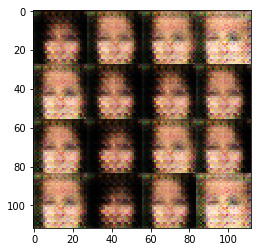

Epoch 1/1... batches 310 Discriminator Loss: 0.3298... Generator Loss: 1.6850
Epoch 1/1... batches 320 Discriminator Loss: 1.0530... Generator Loss: 0.6656
Epoch 1/1... batches 330 Discriminator Loss: 0.2890... Generator Loss: 2.1807
Epoch 1/1... batches 340 Discriminator Loss: 0.5161... Generator Loss: 1.8959
Epoch 1/1... batches 350 Discriminator Loss: 0.7598... Generator Loss: 1.8098
Epoch 1/1... batches 360 Discriminator Loss: 1.2477... Generator Loss: 0.8372
Epoch 1/1... batches 370 Discriminator Loss: 1.1459... Generator Loss: 1.4148
Epoch 1/1... batches 380 Discriminator Loss: 1.9528... Generator Loss: 0.2312
Epoch 1/1... batches 390 Discriminator Loss: 0.6834... Generator Loss: 1.5520
Epoch 1/1... batches 400 Discriminator Loss: 0.7086... Generator Loss: 2.1163


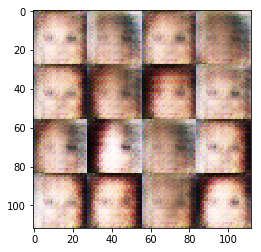

Epoch 1/1... batches 410 Discriminator Loss: 0.4609... Generator Loss: 2.5409
Epoch 1/1... batches 420 Discriminator Loss: 0.7689... Generator Loss: 1.3522
Epoch 1/1... batches 430 Discriminator Loss: 0.9456... Generator Loss: 0.8088
Epoch 1/1... batches 440 Discriminator Loss: 0.6473... Generator Loss: 2.1241
Epoch 1/1... batches 450 Discriminator Loss: 0.8650... Generator Loss: 2.0485
Epoch 1/1... batches 460 Discriminator Loss: 0.7475... Generator Loss: 1.3580
Epoch 1/1... batches 470 Discriminator Loss: 0.6781... Generator Loss: 1.8326
Epoch 1/1... batches 480 Discriminator Loss: 0.6525... Generator Loss: 1.6932
Epoch 1/1... batches 490 Discriminator Loss: 0.6949... Generator Loss: 1.1260
Epoch 1/1... batches 500 Discriminator Loss: 1.0259... Generator Loss: 0.9092


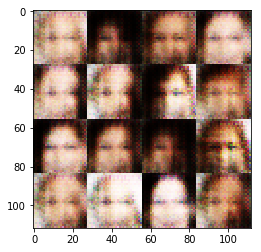

Epoch 1/1... batches 510 Discriminator Loss: 0.7019... Generator Loss: 1.3978
Epoch 1/1... batches 520 Discriminator Loss: 0.6689... Generator Loss: 1.4106
Epoch 1/1... batches 530 Discriminator Loss: 0.5450... Generator Loss: 2.0689
Epoch 1/1... batches 540 Discriminator Loss: 1.1253... Generator Loss: 3.4332
Epoch 1/1... batches 550 Discriminator Loss: 0.7823... Generator Loss: 3.2404
Epoch 1/1... batches 560 Discriminator Loss: 0.7555... Generator Loss: 1.4631
Epoch 1/1... batches 570 Discriminator Loss: 0.6074... Generator Loss: 1.7708
Epoch 1/1... batches 580 Discriminator Loss: 0.7569... Generator Loss: 1.1800
Epoch 1/1... batches 590 Discriminator Loss: 0.6245... Generator Loss: 1.2657
Epoch 1/1... batches 600 Discriminator Loss: 0.5926... Generator Loss: 1.2459


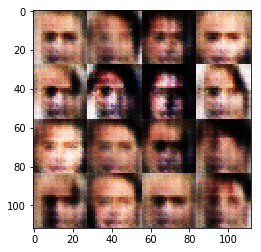

Epoch 1/1... batches 610 Discriminator Loss: 0.7351... Generator Loss: 1.7746
Epoch 1/1... batches 620 Discriminator Loss: 0.9052... Generator Loss: 0.8657
Epoch 1/1... batches 630 Discriminator Loss: 0.7116... Generator Loss: 2.2758
Epoch 1/1... batches 640 Discriminator Loss: 0.4990... Generator Loss: 1.5992
Epoch 1/1... batches 650 Discriminator Loss: 0.4867... Generator Loss: 1.5099
Epoch 1/1... batches 660 Discriminator Loss: 0.8315... Generator Loss: 2.5120
Epoch 1/1... batches 670 Discriminator Loss: 1.0672... Generator Loss: 0.6385
Epoch 1/1... batches 680 Discriminator Loss: 0.3974... Generator Loss: 3.7591
Epoch 1/1... batches 690 Discriminator Loss: 0.4091... Generator Loss: 1.5119
Epoch 1/1... batches 700 Discriminator Loss: 1.5752... Generator Loss: 0.3449


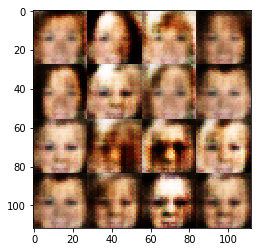

Epoch 1/1... batches 710 Discriminator Loss: 2.5715... Generator Loss: 0.1412
Epoch 1/1... batches 720 Discriminator Loss: 0.5212... Generator Loss: 1.8983
Epoch 1/1... batches 730 Discriminator Loss: 0.6141... Generator Loss: 1.2141
Epoch 1/1... batches 740 Discriminator Loss: 0.3371... Generator Loss: 5.0129
Epoch 1/1... batches 750 Discriminator Loss: 0.9042... Generator Loss: 2.8002
Epoch 1/1... batches 760 Discriminator Loss: 1.1321... Generator Loss: 0.6137
Epoch 1/1... batches 770 Discriminator Loss: 0.6544... Generator Loss: 1.1529
Epoch 1/1... batches 780 Discriminator Loss: 2.3764... Generator Loss: 0.1589
Epoch 1/1... batches 790 Discriminator Loss: 0.7767... Generator Loss: 1.6728
Epoch 1/1... batches 800 Discriminator Loss: 0.9823... Generator Loss: 0.7274


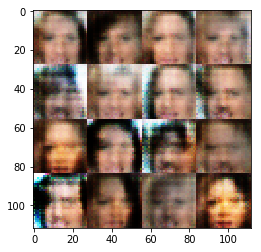

Epoch 1/1... batches 810 Discriminator Loss: 0.9290... Generator Loss: 0.9039
Epoch 1/1... batches 820 Discriminator Loss: 1.0732... Generator Loss: 0.7181
Epoch 1/1... batches 830 Discriminator Loss: 0.9068... Generator Loss: 0.7565
Epoch 1/1... batches 840 Discriminator Loss: 0.6397... Generator Loss: 1.5679
Epoch 1/1... batches 850 Discriminator Loss: 1.2781... Generator Loss: 0.5859
Epoch 1/1... batches 860 Discriminator Loss: 1.0601... Generator Loss: 0.7487
Epoch 1/1... batches 870 Discriminator Loss: 0.6801... Generator Loss: 1.3639
Epoch 1/1... batches 880 Discriminator Loss: 0.4790... Generator Loss: 3.6404
Epoch 1/1... batches 890 Discriminator Loss: 0.4523... Generator Loss: 1.9876
Epoch 1/1... batches 900 Discriminator Loss: 0.3990... Generator Loss: 2.0363


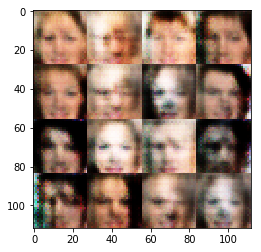

Epoch 1/1... batches 910 Discriminator Loss: 0.8815... Generator Loss: 1.0735
Epoch 1/1... batches 920 Discriminator Loss: 0.7415... Generator Loss: 1.5601
Epoch 1/1... batches 930 Discriminator Loss: 0.9131... Generator Loss: 1.9417
Epoch 1/1... batches 940 Discriminator Loss: 1.1389... Generator Loss: 1.6963
Epoch 1/1... batches 950 Discriminator Loss: 1.2190... Generator Loss: 1.9793
Epoch 1/1... batches 960 Discriminator Loss: 1.6288... Generator Loss: 0.4321
Epoch 1/1... batches 970 Discriminator Loss: 1.1425... Generator Loss: 0.5867
Epoch 1/1... batches 980 Discriminator Loss: 0.9134... Generator Loss: 1.0178
Epoch 1/1... batches 990 Discriminator Loss: 1.1356... Generator Loss: 0.9511
Epoch 1/1... batches 1000 Discriminator Loss: 1.1666... Generator Loss: 0.8311


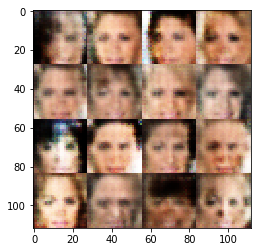

Epoch 1/1... batches 1010 Discriminator Loss: 0.9872... Generator Loss: 1.0298
Epoch 1/1... batches 1020 Discriminator Loss: 0.7666... Generator Loss: 1.6680
Epoch 1/1... batches 1030 Discriminator Loss: 1.0094... Generator Loss: 2.5982
Epoch 1/1... batches 1040 Discriminator Loss: 0.6574... Generator Loss: 1.3589
Epoch 1/1... batches 1050 Discriminator Loss: 0.8702... Generator Loss: 3.0270
Epoch 1/1... batches 1060 Discriminator Loss: 0.8804... Generator Loss: 1.0300
Epoch 1/1... batches 1070 Discriminator Loss: 0.8758... Generator Loss: 3.9702
Epoch 1/1... batches 1080 Discriminator Loss: 0.6716... Generator Loss: 1.4000
Epoch 1/1... batches 1090 Discriminator Loss: 0.9497... Generator Loss: 0.8051
Epoch 1/1... batches 1100 Discriminator Loss: 0.7768... Generator Loss: 1.4795


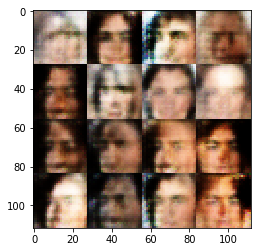

Epoch 1/1... batches 1110 Discriminator Loss: 0.8621... Generator Loss: 1.7675
Epoch 1/1... batches 1120 Discriminator Loss: 0.7977... Generator Loss: 1.0077
Epoch 1/1... batches 1130 Discriminator Loss: 0.6976... Generator Loss: 1.4693
Epoch 1/1... batches 1140 Discriminator Loss: 1.2554... Generator Loss: 0.6227
Epoch 1/1... batches 1150 Discriminator Loss: 0.9013... Generator Loss: 0.9110
Epoch 1/1... batches 1160 Discriminator Loss: 0.9905... Generator Loss: 1.1356
Epoch 1/1... batches 1170 Discriminator Loss: 1.3333... Generator Loss: 0.5038
Epoch 1/1... batches 1180 Discriminator Loss: 1.4216... Generator Loss: 2.6967
Epoch 1/1... batches 1190 Discriminator Loss: 1.3509... Generator Loss: 2.0896
Epoch 1/1... batches 1200 Discriminator Loss: 1.3240... Generator Loss: 0.4760


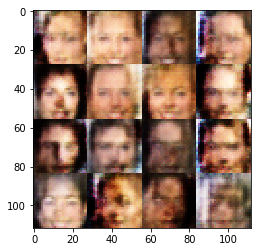

Epoch 1/1... batches 1210 Discriminator Loss: 0.7466... Generator Loss: 1.1471
Epoch 1/1... batches 1220 Discriminator Loss: 0.9082... Generator Loss: 1.1408
Epoch 1/1... batches 1230 Discriminator Loss: 1.0254... Generator Loss: 0.8986
Epoch 1/1... batches 1240 Discriminator Loss: 1.1573... Generator Loss: 0.7163
Epoch 1/1... batches 1250 Discriminator Loss: 1.0717... Generator Loss: 1.0171
Epoch 1/1... batches 1260 Discriminator Loss: 1.3228... Generator Loss: 0.4798
Epoch 1/1... batches 1270 Discriminator Loss: 0.8125... Generator Loss: 0.9728
Epoch 1/1... batches 1280 Discriminator Loss: 0.4645... Generator Loss: 1.7906
Epoch 1/1... batches 1290 Discriminator Loss: 0.8608... Generator Loss: 1.1646
Epoch 1/1... batches 1300 Discriminator Loss: 0.9202... Generator Loss: 1.0244


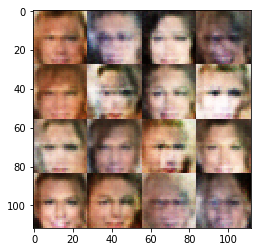

Epoch 1/1... batches 1310 Discriminator Loss: 0.7738... Generator Loss: 1.8444
Epoch 1/1... batches 1320 Discriminator Loss: 1.6293... Generator Loss: 0.3283
Epoch 1/1... batches 1330 Discriminator Loss: 0.8235... Generator Loss: 1.2991
Epoch 1/1... batches 1340 Discriminator Loss: 1.6004... Generator Loss: 0.3366
Epoch 1/1... batches 1350 Discriminator Loss: 0.4178... Generator Loss: 2.7764
Epoch 1/1... batches 1360 Discriminator Loss: 1.0603... Generator Loss: 0.8950
Epoch 1/1... batches 1370 Discriminator Loss: 0.9382... Generator Loss: 1.2796
Epoch 1/1... batches 1380 Discriminator Loss: 0.5536... Generator Loss: 1.9885
Epoch 1/1... batches 1390 Discriminator Loss: 0.9169... Generator Loss: 1.7959
Epoch 1/1... batches 1400 Discriminator Loss: 1.4907... Generator Loss: 0.4573


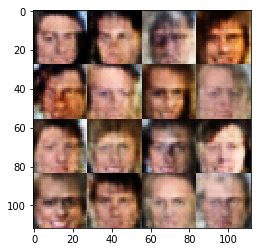

Epoch 1/1... batches 1410 Discriminator Loss: 0.9375... Generator Loss: 1.0994
Epoch 1/1... batches 1420 Discriminator Loss: 0.7708... Generator Loss: 1.2510
Epoch 1/1... batches 1430 Discriminator Loss: 0.8641... Generator Loss: 1.9123
Epoch 1/1... batches 1440 Discriminator Loss: 0.9547... Generator Loss: 1.3558
Epoch 1/1... batches 1450 Discriminator Loss: 1.1396... Generator Loss: 0.7504
Epoch 1/1... batches 1460 Discriminator Loss: 0.9772... Generator Loss: 1.1512
Epoch 1/1... batches 1470 Discriminator Loss: 1.1929... Generator Loss: 1.3384
Epoch 1/1... batches 1480 Discriminator Loss: 1.0589... Generator Loss: 1.0047
Epoch 1/1... batches 1490 Discriminator Loss: 1.0686... Generator Loss: 1.0405
Epoch 1/1... batches 1500 Discriminator Loss: 0.8254... Generator Loss: 1.2210


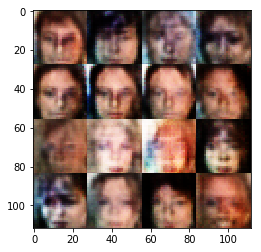

Epoch 1/1... batches 1510 Discriminator Loss: 0.7512... Generator Loss: 1.7003
Epoch 1/1... batches 1520 Discriminator Loss: 1.0686... Generator Loss: 1.4538
Epoch 1/1... batches 1530 Discriminator Loss: 1.3033... Generator Loss: 0.4967
Epoch 1/1... batches 1540 Discriminator Loss: 1.1417... Generator Loss: 0.5670
Epoch 1/1... batches 1550 Discriminator Loss: 0.5577... Generator Loss: 2.4422
Epoch 1/1... batches 1560 Discriminator Loss: 1.1981... Generator Loss: 0.6079
Epoch 1/1... batches 1570 Discriminator Loss: 0.7482... Generator Loss: 1.1172
Epoch 1/1... batches 1580 Discriminator Loss: 0.6642... Generator Loss: 2.4025


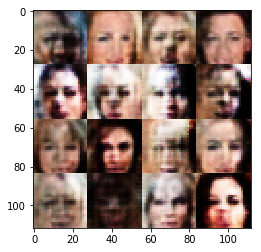

In [93]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5
d_losses = []
g_losses = []


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))

with tf.Graph().as_default():
    d_losses, g_losses = train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

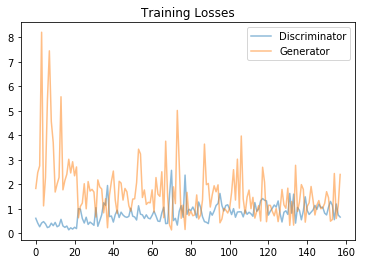

In [94]:
plot_losses(d_losses, g_losses)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.